In [1]:
#import necessary libraries
import warnings
warnings.filterwarnings('ignore')
import time
import math
import calendar
import pickle
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import xgboost as xgb
from math import sqrt
from sklearn import preprocessing
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics       import mean_absolute_error
from sklearn.tree          import DecisionTreeRegressor
from sklearn.model_selection   import GridSearchCV
from sklearn.model_selection   import train_test_split
from sklearn.feature_selection import RFE
from sklearn.linear_model      import Ridge
from IPython.display import display
pd.options.display.max_columns = None
%matplotlib inline

# Project Overview#
Being a football fan and video game lover, I'm very interested in football management simulation video games such as Football Manager developed by Sports Interactive and published by Sega. This game will have a new version every year, containing the new game features and the most important, the newly updated player data. All the game lovers wait for the release of the game every year so that they can be the first batch to player the new version.

As a player of such football management sumulation video games, the most important thing is to have a good knowledge of the players in the market. This is also the basic requirement for a soccer scout.

The idea of the project is to do some exploration on FIFA 19 Complete Player Dataset from kaggle, and create a model/APP which servers as a scouting tool for gamer, club manager, and soccer scout as well.

The model/APP may provide advice to the Football Club Manager, no matter in Video Game, or in real Professional football. And it also can be used as a tool for soccer scout to find a suitable player for a club.

The dataset I used in this project is from Kaggle. It contains detailed attributes for every player registered in the latest edition of FIFA 19 database. The url of the dataset is: https://www.kaggle.com/karangadiya/fifa19

# Problem Statement#

This project aims to provide an algorithm to help the club managers to compare two soccer players, evaluate the market value of a soccer player, and choose the best squad for a club 

To create such a scouting tool, I split the task into below steps:
1. Compare the data value of two players, data visualization
2. Predict the transfer market value of a player
3. Choose the best squad for a club
4. Create a web APP

The plan is to create some functions for the above steps, create and train a prediction model and fine tuning, then use the functions/model to create a Machine Learning Pipeline to achive such function.

# Metrics#

I will use MAE(Mean Absolute Error) as machine learning prediction model evaluation metric. MAE(Mean Absolute Error) is a measure of difference between two continuous variables. The output of the prediction model is the transfer market value of a soccer, which is a continuous variable. So it's suitable to use MAE as the metrics to measure the model performance.

The lower the MAE value is, the better the model performs. 

# Data Understanding #

In [2]:
# Read in the Dataset
FIFA19_df = pd.read_csv('./data.csv')
del FIFA19_df['Unnamed: 0']

FIFA19_df.head()

ID               Name  Age  \
0  158023           L. Messi   31   
1   20801  Cristiano Ronaldo   33   
2  190871          Neymar Jr   26   
3  193080             De Gea   27   
4  192985       K. De Bruyne   27   

                                            Photo Nationality  \
0  https://cdn.sofifa.org/players/4/19/158023.png   Argentina   
1   https://cdn.sofifa.org/players/4/19/20801.png    Portugal   
2  https://cdn.sofifa.org/players/4/19/190871.png      Brazil   
3  https://cdn.sofifa.org/players/4/19/193080.png       Spain   
4  https://cdn.sofifa.org/players/4/19/192985.png     Belgium   

                                  Flag  Overall  Potential  \
0  https://cdn.sofifa.org/flags/52.png       94         94   
1  https://cdn.sofifa.org/flags/38.png       94         94   
2  https://cdn.sofifa.org/flags/54.png       92         93   
3  https://cdn.sofifa.org/flags/45.png       91         93   
4   https://cdn.sofifa.org/flags/7.png       91         92   

                  Club                                     Club Logo    Value  \
0         FC Barcelona  https://cdn.sofifa.org/teams/2/light/241.png  €110.5M   
1             Juventus   https://cdn.sofifa.org/teams/2/light/45.png     €77M   
2  Paris Saint-Germain   https://cdn.sofifa.org/teams/2/light/73.png  €118.5M   
3    Manchester United   https://cdn.sofifa.org/teams/2/light/11.png     €72M   
4      Manchester City   https://cdn.sofifa.org/teams/2/light/10.png    €102M   

    Wage  Special Preferred Foot  International Reputation  Weak Foot  \
0  €565K     2202           Left                       5.0        4.0   
1  €405K     2228          Right                       5.0        4.0   
2  €290K     2143          Right                       5.0        5.0   
3  €260K     1471          Right                       4.0        3.0   
4  €355K     2281          Right                       4.0        5.0   

   Skill Moves       Work Rate   Body Type Real Face Position  Jersey Number  \
0          4.0  Medium/ Medium       Messi       Yes       RF           10.0   
1          5.0       High/ Low  C. Ronaldo       Yes       ST            7.0   
2          5.0    High/ Medium      Neymar       Yes       LW           10.0   
3          1.0  Medium/ Medium        Lean       Yes       GK            1.0   
4          4.0      High/ High      Normal       Yes      RCM            7.0   

         Joined Loaned From Contract Valid Until Height  Weight    LS    ST  \
0   Jul 1, 2004         NaN                 2021    5'7  159lbs  88+2  88+2   
1  Jul 10, 2018         NaN                 2022    6'2  183lbs  91+3  91+3   
2   Aug 3, 2017         NaN                 2022    5'9  150lbs  84+3  84+3   
3   Jul 1, 2011         NaN                 2020    6'4  168lbs   NaN   NaN   
4  Aug 30, 2015         NaN                 2023   5'11  154lbs  82+3  82+3   

     RS    LW    LF    CF    RF    RW   LAM   CAM   RAM    LM   LCM    CM  \
0  88+2  92+2  93+2  93+2  93+2  92+2  93+2  93+2  93+2  91+2  84+2  84+2   
1  91+3  89+3  90+3  90+3  90+3  89+3  88+3  88+3  88+3  88+3  81+3  81+3   
2  84+3  89+3  89+3  89+3  89+3  89+3  89+3  89+3  89+3  88+3  81+3  81+3   
3   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   
4  82+3  87+3  87+3  87+3  87+3  87+3  88+3  88+3  88+3  88+3  87+3  87+3   

    RCM    RM   LWB   LDM   CDM   RDM   RWB    LB   LCB    CB   RCB    RB  \
0  84+2  91+2  64+2  61+2  61+2  61+2  64+2  59+2  47+2  47+2  47+2  59+2   
1  81+3  88+3  65+3  61+3  61+3  61+3  65+3  61+3  53+3  53+3  53+3  61+3   
2  81+3  88+3  65+3  60+3  60+3  60+3  65+3  60+3  47+3  47+3  47+3  60+3   
3   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   
4  87+3  88+3  77+3  77+3  77+3  77+3  77+3  73+3  66+3  66+3  66+3  73+3   

   Crossing  Finishing  HeadingAccuracy  ShortPassing  Volleys  Dribbling  \
0      84.0       95.0             70.0          90.0     86.0       97.0   
1      84.0       94.0             89.0          81.0     

In [3]:
num_rows = FIFA19_df.shape[0] #Provide the number of rows    in the dataset
num_cols = FIFA19_df.shape[1] #Provide the number of columns in the dataset
print("Row    number: {}".format(num_rows))
print("Column number: {}".format(num_cols))

Row    number: 18207
Column number: 88


In [4]:
# check number of duplicates
print('Number of duplicated rows: {} out of {} samples'.format(FIFA19_df.duplicated().sum(),FIFA19_df.shape[0]))

Number of duplicated rows: 0 out of 18207 samples


In [5]:
# Get the Basic info of the dataset
FIFA19_df.describe()

ID           Age       Overall     Potential       Special  \
count   18207.000000  18207.000000  18207.000000  18207.000000  18207.000000   
mean   214298.338606     25.122206     66.238699     71.307299   1597.809908   
std     29965.244204      4.669943      6.908930      6.136496    272.586016   
min        16.000000     16.000000     46.000000     48.000000    731.000000   
25%    200315.500000     21.000000     62.000000     67.000000   1457.000000   
50%    221759.000000     25.000000     66.000000     71.000000   1635.000000   
75%    236529.500000     28.000000     71.000000     75.000000   1787.000000   
max    246620.000000     45.000000     94.000000     95.000000   2346.000000   

       International Reputation     Weak Foot   Skill Moves  Jersey Number  \
count              18159.000000  18159.000000  18159.000000   18147.000000   
mean                   1.113222      2.947299      2.361308      19.546096   
std                    0.394031      0.660456      0.756164      15.947765   
min                    1.000000      1.000000      1.000000       1.000000   
25%                    1.000000      3.000000      2.000000       8.000000   
50%                    1.000000      3.000000      2.000000      17.000000   
75%                    1.000000      3.000000      3.000000      26.000000   
max                    5.000000      5.000000      5.000000      99.000000   

           Crossing     Finishing  HeadingAccuracy  ShortPassing  \
count  18159.000000  18159.000000     18159.000000  18159.000000   
mean      49.734181     45.550911        52.298144     58.686712   
std       18.364524     19.525820        17.379909     14.699495   
min        5.000000      2.000000         4.000000      7.000000   
25%       38.000000     30.000000        44.000000     54.000000   
50%       54.000000     49.000000        56.000000     62.000000   
75%       64.000000     62.000000        64.000000     68.000000   
max       93.000000     95.000000        94.000000     93.000000   

            Volleys     Dribbling         Curve    FKAccuracy   LongPassing  \
count  18159.000000  18159.000000  18159.000000  18159.000000  18159.000000   
mean      42.909026     55.371001     47.170824     42.863153     52.711933   
std       17.694408     18.910371     18.395264     17.478763     15.327870   
min        4.000000      4.000000      6.000000      3.000000      9.000000   
25%       30.000000     49.000000     34.000000     31.000000     43.000000   
50%       44.000000     61.000000     48.000000     41.000000     56.000000   
75%       57.000000     68.000000     62.000000     57.000000     64.000000   
max       90.000000     97.000000     94.000000     94.000000     93.000000   

        BallControl  Acceleration   SprintSpeed       Agility     Reactions  \
count  18159.000000  18159.000000  18159.000000  18159.000000  18159.000000   
mean      58.369459     64.614076     64.726967     63.503607     61.836610   
std       16.686595     14.927780     14.649953     14.766049      9.010464   
min        5.000000     12.000000     12.000000     14.000000     21.000000   
25%       54.000000     57.000000     57.000000     55.000000     56.000000   
50%       63.000000     67.000000     67.000000     66.000000     62.000000   
75%       69.000000     75.000000     75.000000     74.000000     68.000000   
max       96.000000     97.000000     96.000000     96.000000     96.000000   

            Balance     ShotPower       Jumping       Stamina      Strength  \
count  18159.000000  18159.000000  18159.000000  18159.000000  18159.000000   
mean      63.966573     55.460047     65.089432     63.219946     65.311967   
std       14.136166     17.237958     11.820044     15.894741     12.557000   
min       16.000000      2.000000     15.000000     12.000000     17.000000   
25%       56.000000     45.000000     58.000000     56.000000     58.000000   
50%       66.000000     59.000000     66.000000     66.000000     67.000000   
75% 

In [6]:
FIFA19_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18207 entries, 0 to 18206
Data columns (total 88 columns):
ID                          18207 non-null int64
Name                        18207 non-null object
Age                         18207 non-null int64
Photo                       18207 non-null object
Nationality                 18207 non-null object
Flag                        18207 non-null object
Overall                     18207 non-null int64
Potential                   18207 non-null int64
Club                        17966 non-null object
Club Logo                   18207 non-null object
Value                       18207 non-null object
Wage                        18207 non-null object
Special                     18207 non-null int64
Preferred Foot              18159 non-null object
International Reputation    18159 non-null float64
Weak Foot                   18159 non-null float64
Skill Moves                 18159 non-null float64
Work Rate                   18159 non-null 

In [7]:
# Check any Missing Values by column, in Descending order of Missing Value Counts
FIFA19_df.isnull().sum(axis=0).sort_values(ascending=False)

Loaned From             16943
LWB                      2085
LM                       2085
CB                       2085
LCB                      2085
LB                       2085
RWB                      2085
RDM                      2085
CDM                      2085
LDM                      2085
RM                       2085
RCM                      2085
CM                       2085
LCM                      2085
RAM                      2085
RB                       2085
CAM                      2085
LAM                      2085
RW                       2085
RF                       2085
CF                       2085
LF                       2085
LW                       2085
RS                       2085
ST                       2085
LS                       2085
RCB                      2085
Release Clause           1564
Joined                   1553
Contract Valid Until      289
                        ...  
Finishing                  48
Crossing                   48
Positionin

In [8]:
# Check any Missing Values by row, in Descending order of Missing Value Counts
FIFA19_df.isnull().sum(axis=1).sort_values(ascending=False)

13244    75
13267    75
13240    75
13265    75
13264    75
13282    75
13236    75
13243    75
13249    75
13237    75
13263    75
13262    75
13238    75
13261    75
13260    75
13259    75
13258    75
13257    75
13281    75
13256    75
13255    75
13254    75
13253    75
13252    75
13251    75
13239    75
13280    75
13266    75
13248    75
13283    75
         ..
11372     1
11373     1
11402     1
11401     1
11400     1
11399     1
11398     1
11397     1
11396     1
11395     1
11394     1
11393     1
11392     1
11391     1
11390     1
11388     1
11387     1
11386     1
11385     1
11384     1
11383     1
11382     1
11381     1
11380     1
11378     1
11377     1
11376     1
11375     1
11374     1
0         1
Length: 18207, dtype: int64

In [9]:
# Columns
FIFA19_df.columns

Index(['ID', 'Name', 'Age', 'Photo', 'Nationality', 'Flag', 'Overall',
       'Potential', 'Club', 'Club Logo', 'Value', 'Wage', 'Special',
       'Preferred Foot', 'International Reputation', 'Weak Foot',
       'Skill Moves', 'Work Rate', 'Body Type', 'Real Face', 'Position',
       'Jersey Number', 'Joined', 'Loaned From', 'Contract Valid Until',
       'Height', 'Weight', 'LS', 'ST', 'RS', 'LW', 'LF', 'CF', 'RF', 'RW',
       'LAM', 'CAM', 'RAM', 'LM', 'LCM', 'CM', 'RCM', 'RM', 'LWB', 'LDM',
       'CDM', 'RDM', 'RWB', 'LB', 'LCB', 'CB', 'RCB', 'RB', 'Crossing',
       'Finishing', 'HeadingAccuracy', 'ShortPassing', 'Volleys', 'Dribbling',
       'Curve', 'FKAccuracy', 'LongPassing', 'BallControl', 'Acceleration',
       'SprintSpeed', 'Agility', 'Reactions', 'Balance', 'ShotPower',
       'Jumping', 'Stamina', 'Strength', 'LongShots', 'Aggression',
       'Interceptions', 'Positioning', 'Vision', 'Penalties', 'Composure',
       'Marking', 'StandingTackle', 'SlidingTackle', 'GKDiv

# Data Preprocessing#
## 1. Dealing with Missing Values##

First we check the Missing Value by row. From the sorted list in last part, I found that there are a group of players data has 75 missing values each, 75/88=85.22% data missing. Thus I think these data entries are also useless to this project. So I just drop these rows with 75 missing values

In [10]:
#Keep only the rows with at least half non-NA values.
FIFA19_df.dropna(thresh=14, inplace=True)

In [11]:
# Check the current Top 10 missing value count by row
FIFA19_df.isnull().sum(axis=1).sort_values(ascending=False).head(10)

17539    33
6736     33
5018     33
9905     33
16450    33
16539    33
17339    33
10628    33
7922     33
17436    33
dtype: int64

In [12]:
#Check the current Top 10 missing value count by column
FIFA19_df.isnull().sum(axis=0).sort_values(ascending=False).head(10)

Loaned From    16895
LWB             2037
LM              2037
CB              2037
LCB             2037
LB              2037
RWB             2037
RDM             2037
CDM             2037
LDM             2037
dtype: int64

Next look at missing value count by columns. The feature "Loaned From" has 16895 missing values, more than 92% of "Loaned From" values
are missing values. Thus this feature is useless to the project. Simply drop this column will do.

In [13]:
#Drop Column "Loaned From"
FIFA19_df.drop('Loaned From', axis=1,inplace=True)

For players whose "position" is GK, the Ratings of other positions (such as feature "LDM", "RB", etc.) are empty. It's reasonable as GK usually is very specific position and most GKs are weak when play as other roles. So we can fill the position columns of GKs zero.

In [14]:
#For GK, fill missing value at other positions as "0+0"
Position_List = ['LS', 'ST', 'RS', 'LW', 'LF', 'CF', 'RF', 'RW', 'LAM', 'CAM', 'RAM', 'LM', 'LCM',
                 'CM', 'RCM', 'RM', 'LWB', 'LDM', 'CDM', 'RDM', 'RWB', 'LB', 'LCB', 'CB', 'RCB', 'RB']
FIFA19_df.loc[FIFA19_df.Position == 'GK', Position_List] = '0+0'

In [15]:
#Check the current Top 10 missing value count by column
FIFA19_df.isnull().sum(axis=0).sort_values(ascending=False).head(10)

Release Clause          1516
Joined                  1505
Club                     241
Contract Valid Until     241
CDM                       12
LCM                       12
CM                        12
RCM                       12
RM                        12
LWB                       12
dtype: int64

Next, Feature "Release Clause" means if another club willing to pay this amount, the club which owns the player must let go the player to join the club which pay the amount in Release Clause. Thus for any Missing Value in "Release Clause", we can just fill it with 0.

In [16]:
#Fill Missing Value in "Release Clause" with "€0"
FIFA19_df['Release Clause'].fillna(value='€0', inplace=True)

Feature "Joined" represents the date that this player joined the club. From common sense this feature is unimportant. When did the player join the club has nothing to do with his performance, wage, value, etc. So we can simply drop it.

In [17]:
#Drop Column "Joined"
FIFA19_df.drop('Joined', axis=1,inplace=True)

For Missing Values in "Club" usually means that this player doesn't belong to any club right now, it also means this player is not bonded by a contract. It's also an important information. So I just fill the missiong value in "Club" with "Free Contract"

In [18]:
#Fill Missing Value in "Club" with "Free Contract"
FIFA19_df['Club'].fillna(value='Free Contract', inplace=True)

Feature "Contract Valid Until" means when the current contract ends. The longer the contract length left, the higher the transfer market price of this player. A missing value in "Contract Valid Until" probably means this player is a free player who do not have a contract right now. For easy process in next data processing steps, I just put today's date to replace the missing value. This also means that the player has no contract at all right now.

In [19]:
#Fill Missing Value in "Contract Valid Until" with today's date
FIFA19_df['Contract Valid Until'].fillna(value=time.strftime("%d-%m-%Y", time.localtime()), inplace=True)

In [20]:
#Check the current missing value count by column
FIFA19_df.isnull().sum(axis=0).sort_values(ascending=False).head(30)

LDM              12
CB               12
ST               12
RS               12
LW               12
LF               12
CF               12
RF               12
RW               12
LAM              12
RB               12
RCB              12
LCB              12
RAM              12
LB               12
RWB              12
RDM              12
CDM              12
CAM              12
LWB              12
RM               12
RCM              12
CM               12
LCM              12
LS               12
LM               12
Jersey Number    12
Position         12
Height            0
Value             0
dtype: int64

In [21]:
# Check the current missing value count by row
FIFA19_df.isnull().sum(axis=1).sort_values(ascending=False).head(15)

16539    28
6736     28
9905     28
17539    28
17436    28
17129    28
16793    28
7922     28
17339    28
16450    28
10628    28
5018     28
6051      0
6050      0
6045      0
dtype: int64

Now we still have 12 rows with missing value, these missing values are Position Ratings, Jersey Number, and Position. As without the Position and the Position Ratings, we don't know the role of these players. The number of rows with missing value is quite small comparing to the total number of rows. So I think we can just drop these rows.

In [22]:
FIFA19_df.dropna(axis=0, inplace=True)

In [23]:
#Check the current missing value count by column
FIFA19_df.isnull().sum(axis=0).sort_values(ascending=False).head(5)

Release Clause    0
RF                0
Height            0
Weight            0
LS                0
dtype: int64

In [24]:
# Check the current missing value count by row
FIFA19_df.isnull().sum(axis=1).sort_values(ascending=False).head(5)

18206    0
6052     0
6046     0
6047     0
6048     0
dtype: int64

After removing Missing Value, check the shape of the dataset again

In [25]:
num_rows = FIFA19_df.shape[0] #Provide the number of rows    in the dataset
num_cols = FIFA19_df.shape[1] #Provide the number of columns in the dataset
print("Row    number: {}".format(num_rows))
print("Column number: {}".format(num_cols))

Row    number: 18147
Column number: 86


Total 18207-18147=60, 0.33% of rows removed;
Total 88-86=2, 2.27% of columns removed.
I think it's within acceptable range. Now we have a dataset without missing values.

## 2. Convert string/date values into numbers##

For Currency amount "Value", "Wage", "Release Clause", convert the amount from string values into numbers(in thousands). Here I use a function str2number.

In [26]:
# Supporting function to convert string values into numbers
def str2number(amount):
    """
    This function perform convertion from amount values in string type to float type numbers
    
    Parameter:
    amount(str): Amount values in string type with M & K as Abbreviation for Million and Thousands
    
    Returns:
    float: A float number represents the numerical value of the input parameter amount(str)
    """
    if amount[-1] == 'M':
        return float(amount[1:-1])*1000000
    elif amount[-1] == 'K':
        return float(amount[1:-1])*1000
    else:
        return float(amount[1:])

In [27]:
#Create New Value_Number_K column to store numerical type Value info
FIFA19_df['Value_Number_K'] = FIFA19_df['Value'].map(lambda x: str2number(x)/1000)

# Create New Wage_Number_K column to store numerical type Wage info
FIFA19_df['Wage_Number_K']  = FIFA19_df['Wage'].map(lambda x: str2number(x)/1000)

# Create New ReleaseClause_Number_K column to store numerical type ReleaseClause info
FIFA19_df['ReleaseClause_Number_K']  = FIFA19_df['Release Clause'].map(lambda x: str2number(x)/1000)

In [28]:
FIFA19_df.head(10)

ID               Name  Age  \
0  158023           L. Messi   31   
1   20801  Cristiano Ronaldo   33   
2  190871          Neymar Jr   26   
3  193080             De Gea   27   
4  192985       K. De Bruyne   27   
5  183277          E. Hazard   27   
6  177003          L. Modrić   32   
7  176580          L. Suárez   31   
8  155862       Sergio Ramos   32   
9  200389           J. Oblak   25   

                                            Photo Nationality  \
0  https://cdn.sofifa.org/players/4/19/158023.png   Argentina   
1   https://cdn.sofifa.org/players/4/19/20801.png    Portugal   
2  https://cdn.sofifa.org/players/4/19/190871.png      Brazil   
3  https://cdn.sofifa.org/players/4/19/193080.png       Spain   
4  https://cdn.sofifa.org/players/4/19/192985.png     Belgium   
5  https://cdn.sofifa.org/players/4/19/183277.png     Belgium   
6  https://cdn.sofifa.org/players/4/19/177003.png     Croatia   
7  https://cdn.sofifa.org/players/4/19/176580.png     Uruguay   
8  https://cdn.sofifa.org/players/4/19/155862.png       Spain   
9  https://cdn.sofifa.org/players/4/19/200389.png    Slovenia   

                                  Flag  Overall  Potential  \
0  https://cdn.sofifa.org/flags/52.png       94         94   
1  https://cdn.sofifa.org/flags/38.png       94         94   
2  https://cdn.sofifa.org/flags/54.png       92         93   
3  https://cdn.sofifa.org/flags/45.png       91         93   
4   https://cdn.sofifa.org/flags/7.png       91         92   
5   https://cdn.sofifa.org/flags/7.png       91         91   
6  https://cdn.sofifa.org/flags/10.png       91         91   
7  https://cdn.sofifa.org/flags/60.png       91         91   
8  https://cdn.sofifa.org/flags/45.png       91         91   
9  https://cdn.sofifa.org/flags/44.png       90         93   

                  Club                                     Club Logo    Value  \
0         FC Barcelona  https://cdn.sofifa.org/teams/2/light/241.png  €110.5M   
1             Juventus   https://cdn.sofifa.org/teams/2/light/45.png     €77M   
2  Paris Saint-Germain   https://cdn.sofifa.org/teams/2/light/73.png  €118.5M   
3    Manchester United   https://cdn.sofifa.org/teams/2/light/11.png     €72M   
4      Manchester City   https://cdn.sofifa.org/teams/2/light/10.png    €102M   
5              Chelsea    https://cdn.sofifa.org/teams/2/light/5.png     €93M   
6          Real Madrid  https://cdn.sofifa.org/teams/2/light/243.png     €67M   
7         FC Barcelona  https://cdn.sofifa.org/teams/2/light/241.png     €80M   
8          Real Madrid  https://cdn.sofifa.org/teams/2/light/243.png     €51M   
9      Atlético Madrid  https://cdn.sofifa.org/teams/2/light/240.png     €68M   

    Wage  Special Preferred Foot  International Reputation  Weak Foot  \
0  €565K     2202           Left                       5.0        4.0   
1  €405K     2228          Right                       5.0        4.0   
2  €290K     2143          Right                       5.0        5.0   
3  €260K     1471          Right                       4.0        3.0   
4  €355K     2281          Right                       4.0        5.0   
5  €340K     2142          Right                       4.0        4.0   
6  €420K     2280          Right                       4.0        4.0   
7  €455K     2346          Right                       5.0        4.0   
8  €380K     2201          Right                       4.0        3.0   
9   €94K     1331          Right                       3.0        3.0   

   Skill Moves       Work Rate   Body Type Real Face Position  Jersey Number  \
0          4.0  Medium/ Medium       Messi       Yes       RF           10.0   
1          5.0       High/ Low  C. Ronaldo       Yes       ST            7.0   
2          5.0    High/ Medium      Neymar       Yes       LW           10.0   
3          1.0  Medium/ Medium        Lean       Yes       GK            1.0   
4          4.0      High/ High      Normal       Yes      RCM            7.0   
5          4.0    High/ 

For column "Contract Valid Until", we need to convert the value into numerical value represents the remaining months of the player's contract. There are two types of values in this column: Numerical Year number only, and complete date type DD-MMM-YYYY. So I create a function to convert the two types of values of date, into the remaining months numbers from current date.

In [29]:
# Supporting function to convert two types of date values into remaining months numbers from the current date
def date2monthsnumber(date):
    """
    This function perform convertion from two types of date values into remaining months numbers from the current date
    Type 1: Just year number YYYY.            For example, 2021
    Type 2: Complete date format DD-MMM-YYYY. For example, 28-Jul-2017
    
    Parameter:
    date(str): Two types of date representation as stated above
    
    Returns:
    Numerical: A number represents the remaining months numbers from the current date
    """
    
    current_month = int(time.strftime("%m", time.localtime()))
    current_year  = int(time.strftime("%Y", time.localtime()))
    
    if (len(str(date)) == 12) or (len(str(date)) == 11):
        month,day,year = date.split(" ")
        contract_end_month = dict((v,k) for k,v in enumerate(calendar.month_abbr))[month]
        contract_end_year  = int(year)
        contract_remain_month = int((contract_end_year-current_year)*12 + (contract_end_month-current_month))
        if contract_remain_month < 0:
            return 0
        else:
            return contract_remain_month
        
    elif len(str(date)) ==  10:
        day,month,year = date.split("-")
        contract_end_month = int(month)
        contract_end_year  = int(year)
        contract_remain_month = int((contract_end_year-current_year)*12 + (contract_end_month-current_month))
        if contract_remain_month < 0:
            return 0
        else:
            return contract_remain_month

    elif len(str(date)) ==  4:
        contract_end_month = 12
        contract_end_year  = int(date)
        contract_remain_month = int((contract_end_year-current_year)*12 + (contract_end_month-current_month))   
        if contract_remain_month < 0:
            return 0
        else:
            return contract_remain_month

In [30]:
#Create New Contract_Remaining_Month_Number column to store numerical type Remaining Contract info
FIFA19_df['Contract_Remaining_Month_Number'] = FIFA19_df['Contract Valid Until'].map(lambda x: date2monthsnumber(x))

In [31]:
FIFA19_df.head(10)

ID               Name  Age  \
0  158023           L. Messi   31   
1   20801  Cristiano Ronaldo   33   
2  190871          Neymar Jr   26   
3  193080             De Gea   27   
4  192985       K. De Bruyne   27   
5  183277          E. Hazard   27   
6  177003          L. Modrić   32   
7  176580          L. Suárez   31   
8  155862       Sergio Ramos   32   
9  200389           J. Oblak   25   

                                            Photo Nationality  \
0  https://cdn.sofifa.org/players/4/19/158023.png   Argentina   
1   https://cdn.sofifa.org/players/4/19/20801.png    Portugal   
2  https://cdn.sofifa.org/players/4/19/190871.png      Brazil   
3  https://cdn.sofifa.org/players/4/19/193080.png       Spain   
4  https://cdn.sofifa.org/players/4/19/192985.png     Belgium   
5  https://cdn.sofifa.org/players/4/19/183277.png     Belgium   
6  https://cdn.sofifa.org/players/4/19/177003.png     Croatia   
7  https://cdn.sofifa.org/players/4/19/176580.png     Uruguay   
8  https://cdn.sofifa.org/players/4/19/155862.png       Spain   
9  https://cdn.sofifa.org/players/4/19/200389.png    Slovenia   

                                  Flag  Overall  Potential  \
0  https://cdn.sofifa.org/flags/52.png       94         94   
1  https://cdn.sofifa.org/flags/38.png       94         94   
2  https://cdn.sofifa.org/flags/54.png       92         93   
3  https://cdn.sofifa.org/flags/45.png       91         93   
4   https://cdn.sofifa.org/flags/7.png       91         92   
5   https://cdn.sofifa.org/flags/7.png       91         91   
6  https://cdn.sofifa.org/flags/10.png       91         91   
7  https://cdn.sofifa.org/flags/60.png       91         91   
8  https://cdn.sofifa.org/flags/45.png       91         91   
9  https://cdn.sofifa.org/flags/44.png       90         93   

                  Club                                     Club Logo    Value  \
0         FC Barcelona  https://cdn.sofifa.org/teams/2/light/241.png  €110.5M   
1             Juventus   https://cdn.sofifa.org/teams/2/light/45.png     €77M   
2  Paris Saint-Germain   https://cdn.sofifa.org/teams/2/light/73.png  €118.5M   
3    Manchester United   https://cdn.sofifa.org/teams/2/light/11.png     €72M   
4      Manchester City   https://cdn.sofifa.org/teams/2/light/10.png    €102M   
5              Chelsea    https://cdn.sofifa.org/teams/2/light/5.png     €93M   
6          Real Madrid  https://cdn.sofifa.org/teams/2/light/243.png     €67M   
7         FC Barcelona  https://cdn.sofifa.org/teams/2/light/241.png     €80M   
8          Real Madrid  https://cdn.sofifa.org/teams/2/light/243.png     €51M   
9      Atlético Madrid  https://cdn.sofifa.org/teams/2/light/240.png     €68M   

    Wage  Special Preferred Foot  International Reputation  Weak Foot  \
0  €565K     2202           Left                       5.0        4.0   
1  €405K     2228          Right                       5.0        4.0   
2  €290K     2143          Right                       5.0        5.0   
3  €260K     1471          Right                       4.0        3.0   
4  €355K     2281          Right                       4.0        5.0   
5  €340K     2142          Right                       4.0        4.0   
6  €420K     2280          Right                       4.0        4.0   
7  €455K     2346          Right                       5.0        4.0   
8  €380K     2201          Right                       4.0        3.0   
9   €94K     1331          Right                       3.0        3.0   

   Skill Moves       Work Rate   Body Type Real Face Position  Jersey Number  \
0          4.0  Medium/ Medium       Messi       Yes       RF           10.0   
1          5.0       High/ Low  C. Ronaldo       Yes       ST            7.0   
2          5.0    High/ Medium      Neymar       Yes       LW           10.0   
3          1.0  Medium/ Medium        Lean       Yes       GK            1.0   
4          4.0      High/ High      Normal       Yes      RCM            7.0   
5          4.0    High/ 

For Position Ratings, the data contains the previous rating and also the increment. The increment may also carries important information. Thus I will calculate the final rating and the increment part as well. I will create a function to do the job.

In [32]:
# Supporting function to convert str type Position Rating into final rating & increment as well
def rating2finalandincrement(rating,return_type):
    """
    This function perform convertion from str type Position Rating into final rating & increment as well
    
    Parameter:
    rating(str):      Position Rating Expression
    return_type(str): Type of the return value
    
    Returns:
    Numerical: For return_type == "final",    returns a number represents the final     rating of this player at this position
               For return_type == "increment, returns a number represents the increment rating of this player at this position
    """
    final_rating,increment_rating = rating.split("+")
    
    if return_type == "final":
        return int(final_rating) + int(increment_rating)
    elif return_type == "increment":
        return int(increment_rating)

In [33]:
Increment_List= []
for pos in Position_List:
    new_column_name_Final     = pos+"_Final"
    new_column_name_Increment = pos+"_Increment"
    FIFA19_df[new_column_name_Final]     = FIFA19_df[pos].map(lambda x: rating2finalandincrement(str(x),"final"))
    FIFA19_df[new_column_name_Increment] = FIFA19_df[pos].map(lambda x: rating2finalandincrement(str(x),"increment"))
    Increment_List.append(new_column_name_Increment)

In [34]:
FIFA19_df['Total_Increment'] = FIFA19_df[Increment_List].sum(axis=1)
FIFA19_df.drop(Increment_List, axis=1,inplace=True)

In [35]:
FIFA19_df.head(10)

ID               Name  Age  \
0  158023           L. Messi   31   
1   20801  Cristiano Ronaldo   33   
2  190871          Neymar Jr   26   
3  193080             De Gea   27   
4  192985       K. De Bruyne   27   
5  183277          E. Hazard   27   
6  177003          L. Modrić   32   
7  176580          L. Suárez   31   
8  155862       Sergio Ramos   32   
9  200389           J. Oblak   25   

                                            Photo Nationality  \
0  https://cdn.sofifa.org/players/4/19/158023.png   Argentina   
1   https://cdn.sofifa.org/players/4/19/20801.png    Portugal   
2  https://cdn.sofifa.org/players/4/19/190871.png      Brazil   
3  https://cdn.sofifa.org/players/4/19/193080.png       Spain   
4  https://cdn.sofifa.org/players/4/19/192985.png     Belgium   
5  https://cdn.sofifa.org/players/4/19/183277.png     Belgium   
6  https://cdn.sofifa.org/players/4/19/177003.png     Croatia   
7  https://cdn.sofifa.org/players/4/19/176580.png     Uruguay   
8  https://cdn.sofifa.org/players/4/19/155862.png       Spain   
9  https://cdn.sofifa.org/players/4/19/200389.png    Slovenia   

                                  Flag  Overall  Potential  \
0  https://cdn.sofifa.org/flags/52.png       94         94   
1  https://cdn.sofifa.org/flags/38.png       94         94   
2  https://cdn.sofifa.org/flags/54.png       92         93   
3  https://cdn.sofifa.org/flags/45.png       91         93   
4   https://cdn.sofifa.org/flags/7.png       91         92   
5   https://cdn.sofifa.org/flags/7.png       91         91   
6  https://cdn.sofifa.org/flags/10.png       91         91   
7  https://cdn.sofifa.org/flags/60.png       91         91   
8  https://cdn.sofifa.org/flags/45.png       91         91   
9  https://cdn.sofifa.org/flags/44.png       90         93   

                  Club                                     Club Logo    Value  \
0         FC Barcelona  https://cdn.sofifa.org/teams/2/light/241.png  €110.5M   
1             Juventus   https://cdn.sofifa.org/teams/2/light/45.png     €77M   
2  Paris Saint-Germain   https://cdn.sofifa.org/teams/2/light/73.png  €118.5M   
3    Manchester United   https://cdn.sofifa.org/teams/2/light/11.png     €72M   
4      Manchester City   https://cdn.sofifa.org/teams/2/light/10.png    €102M   
5              Chelsea    https://cdn.sofifa.org/teams/2/light/5.png     €93M   
6          Real Madrid  https://cdn.sofifa.org/teams/2/light/243.png     €67M   
7         FC Barcelona  https://cdn.sofifa.org/teams/2/light/241.png     €80M   
8          Real Madrid  https://cdn.sofifa.org/teams/2/light/243.png     €51M   
9      Atlético Madrid  https://cdn.sofifa.org/teams/2/light/240.png     €68M   

    Wage  Special Preferred Foot  International Reputation  Weak Foot  \
0  €565K     2202           Left                       5.0        4.0   
1  €405K     2228          Right                       5.0        4.0   
2  €290K     2143          Right                       5.0        5.0   
3  €260K     1471          Right                       4.0        3.0   
4  €355K     2281          Right                       4.0        5.0   
5  €340K     2142          Right                       4.0        4.0   
6  €420K     2280          Right                       4.0        4.0   
7  €455K     2346          Right                       5.0        4.0   
8  €380K     2201          Right                       4.0        3.0   
9   €94K     1331          Right                       3.0        3.0   

   Skill Moves       Work Rate   Body Type Real Face Position  Jersey Number  \
0          4.0  Medium/ Medium       Messi       Yes       RF           10.0   
1          5.0       High/ Low  C. Ronaldo       Yes       ST            7.0   
2          5.0    High/ Medium      Neymar       Yes       LW           10.0   
3          1.0  Medium/ Medium        Lean       Yes       GK            1.0   
4          4.0      High/ High      Normal       Yes      RCM            7.0   
5          4.0    High/ 

## 3. Dealing with categorical features #

For categorical features such as "Nationality", "Club", "Work Rate", "Body Type", "Preferred Foot", and "Position", we need to do one-hot encoding before feeding the data into the model to be created later.

In [36]:
# One-hot encode the feature: "Nationality", "Club", "Work Rate", "Body Type", "Preferred Foot", and "Position"
le = LabelEncoder()
FIFA19_df['Nationality_onehot_encode']   = le.fit_transform(FIFA19_df['Nationality'])
FIFA19_df['Club_onehot_encode']          = le.fit_transform(FIFA19_df['Club'])
FIFA19_df['WorkRate_onehot_encode']      = le.fit_transform(FIFA19_df['Work Rate'])
FIFA19_df['BodyType_onehot_encode']      = le.fit_transform(FIFA19_df['Body Type'])
FIFA19_df['PreferredFoot_onehot_encode'] = le.fit_transform(FIFA19_df['Preferred Foot'])
FIFA19_df['Position_onehot_encode']      = le.fit_transform(FIFA19_df['Position'])

In [37]:
FIFA19_df.head(10)

ID               Name  Age  \
0  158023           L. Messi   31   
1   20801  Cristiano Ronaldo   33   
2  190871          Neymar Jr   26   
3  193080             De Gea   27   
4  192985       K. De Bruyne   27   
5  183277          E. Hazard   27   
6  177003          L. Modrić   32   
7  176580          L. Suárez   31   
8  155862       Sergio Ramos   32   
9  200389           J. Oblak   25   

                                            Photo Nationality  \
0  https://cdn.sofifa.org/players/4/19/158023.png   Argentina   
1   https://cdn.sofifa.org/players/4/19/20801.png    Portugal   
2  https://cdn.sofifa.org/players/4/19/190871.png      Brazil   
3  https://cdn.sofifa.org/players/4/19/193080.png       Spain   
4  https://cdn.sofifa.org/players/4/19/192985.png     Belgium   
5  https://cdn.sofifa.org/players/4/19/183277.png     Belgium   
6  https://cdn.sofifa.org/players/4/19/177003.png     Croatia   
7  https://cdn.sofifa.org/players/4/19/176580.png     Uruguay   
8  https://cdn.sofifa.org/players/4/19/155862.png       Spain   
9  https://cdn.sofifa.org/players/4/19/200389.png    Slovenia   

                                  Flag  Overall  Potential  \
0  https://cdn.sofifa.org/flags/52.png       94         94   
1  https://cdn.sofifa.org/flags/38.png       94         94   
2  https://cdn.sofifa.org/flags/54.png       92         93   
3  https://cdn.sofifa.org/flags/45.png       91         93   
4   https://cdn.sofifa.org/flags/7.png       91         92   
5   https://cdn.sofifa.org/flags/7.png       91         91   
6  https://cdn.sofifa.org/flags/10.png       91         91   
7  https://cdn.sofifa.org/flags/60.png       91         91   
8  https://cdn.sofifa.org/flags/45.png       91         91   
9  https://cdn.sofifa.org/flags/44.png       90         93   

                  Club                                     Club Logo    Value  \
0         FC Barcelona  https://cdn.sofifa.org/teams/2/light/241.png  €110.5M   
1             Juventus   https://cdn.sofifa.org/teams/2/light/45.png     €77M   
2  Paris Saint-Germain   https://cdn.sofifa.org/teams/2/light/73.png  €118.5M   
3    Manchester United   https://cdn.sofifa.org/teams/2/light/11.png     €72M   
4      Manchester City   https://cdn.sofifa.org/teams/2/light/10.png    €102M   
5              Chelsea    https://cdn.sofifa.org/teams/2/light/5.png     €93M   
6          Real Madrid  https://cdn.sofifa.org/teams/2/light/243.png     €67M   
7         FC Barcelona  https://cdn.sofifa.org/teams/2/light/241.png     €80M   
8          Real Madrid  https://cdn.sofifa.org/teams/2/light/243.png     €51M   
9      Atlético Madrid  https://cdn.sofifa.org/teams/2/light/240.png     €68M   

    Wage  Special Preferred Foot  International Reputation  Weak Foot  \
0  €565K     2202           Left                       5.0        4.0   
1  €405K     2228          Right                       5.0        4.0   
2  €290K     2143          Right                       5.0        5.0   
3  €260K     1471          Right                       4.0        3.0   
4  €355K     2281          Right                       4.0        5.0   
5  €340K     2142          Right                       4.0        4.0   
6  €420K     2280          Right                       4.0        4.0   
7  €455K     2346          Right                       5.0        4.0   
8  €380K     2201          Right                       4.0        3.0   
9   €94K     1331          Right                       3.0        3.0   

   Skill Moves       Work Rate   Body Type Real Face Position  Jersey Number  \
0          4.0  Medium/ Medium       Messi       Yes       RF           10.0   
1          5.0       High/ Low  C. Ronaldo       Yes       ST            7.0   
2          5.0    High/ Medium      Neymar       Yes       LW           10.0   
3          1.0  Medium/ Medium        Lean       Yes       GK            1.0   
4          4.0      High/ High      Normal       Yes      RCM            7.0   
5          4.0    High/ 

## 4. Normalization of feature "Height", "Weight"#

In [38]:
# Supporting function to convert Height & Weight to float number
def convertHeightWeight2floatnumber(data,type):
    """
    This function perform convertion from str type Height & Weight into floating number type
    
    Parameter:
    data(str): Height/Weight
    type(str): Type of the data, Height or Weight
    
    Returns:
    Numerical: floating number of Height/Weight
    """
   
    if type == "Height":
        a,b=data.split("'")
        return float(a)+float(b)/10
    elif type == "Weight":
        c=data[0:-3]
        return float(c)

In [39]:
# Normalization of feature "Height", "Weight" using min max normalization
FIFA19_df['Height_float'] = FIFA19_df['Height'].map(lambda x: convertHeightWeight2floatnumber(str(x),"Height"))
FIFA19_df['Weight_float'] = FIFA19_df['Weight'].map(lambda x: convertHeightWeight2floatnumber(str(x),"Weight"))
FIFA19_df['Height_Normalized'] = (FIFA19_df['Height_float'] - FIFA19_df['Height_float'].min())/(FIFA19_df['Height_float'].max() - FIFA19_df['Height_float'].min())
FIFA19_df['Weight_Normalized'] = (FIFA19_df['Weight_float'] - FIFA19_df['Weight_float'].min())/(FIFA19_df['Weight_float'].max() - FIFA19_df['Weight_float'].min())

In [40]:
FIFA19_df.head(10)

ID               Name  Age  \
0  158023           L. Messi   31   
1   20801  Cristiano Ronaldo   33   
2  190871          Neymar Jr   26   
3  193080             De Gea   27   
4  192985       K. De Bruyne   27   
5  183277          E. Hazard   27   
6  177003          L. Modrić   32   
7  176580          L. Suárez   31   
8  155862       Sergio Ramos   32   
9  200389           J. Oblak   25   

                                            Photo Nationality  \
0  https://cdn.sofifa.org/players/4/19/158023.png   Argentina   
1   https://cdn.sofifa.org/players/4/19/20801.png    Portugal   
2  https://cdn.sofifa.org/players/4/19/190871.png      Brazil   
3  https://cdn.sofifa.org/players/4/19/193080.png       Spain   
4  https://cdn.sofifa.org/players/4/19/192985.png     Belgium   
5  https://cdn.sofifa.org/players/4/19/183277.png     Belgium   
6  https://cdn.sofifa.org/players/4/19/177003.png     Croatia   
7  https://cdn.sofifa.org/players/4/19/176580.png     Uruguay   
8  https://cdn.sofifa.org/players/4/19/155862.png       Spain   
9  https://cdn.sofifa.org/players/4/19/200389.png    Slovenia   

                                  Flag  Overall  Potential  \
0  https://cdn.sofifa.org/flags/52.png       94         94   
1  https://cdn.sofifa.org/flags/38.png       94         94   
2  https://cdn.sofifa.org/flags/54.png       92         93   
3  https://cdn.sofifa.org/flags/45.png       91         93   
4   https://cdn.sofifa.org/flags/7.png       91         92   
5   https://cdn.sofifa.org/flags/7.png       91         91   
6  https://cdn.sofifa.org/flags/10.png       91         91   
7  https://cdn.sofifa.org/flags/60.png       91         91   
8  https://cdn.sofifa.org/flags/45.png       91         91   
9  https://cdn.sofifa.org/flags/44.png       90         93   

                  Club                                     Club Logo    Value  \
0         FC Barcelona  https://cdn.sofifa.org/teams/2/light/241.png  €110.5M   
1             Juventus   https://cdn.sofifa.org/teams/2/light/45.png     €77M   
2  Paris Saint-Germain   https://cdn.sofifa.org/teams/2/light/73.png  €118.5M   
3    Manchester United   https://cdn.sofifa.org/teams/2/light/11.png     €72M   
4      Manchester City   https://cdn.sofifa.org/teams/2/light/10.png    €102M   
5              Chelsea    https://cdn.sofifa.org/teams/2/light/5.png     €93M   
6          Real Madrid  https://cdn.sofifa.org/teams/2/light/243.png     €67M   
7         FC Barcelona  https://cdn.sofifa.org/teams/2/light/241.png     €80M   
8          Real Madrid  https://cdn.sofifa.org/teams/2/light/243.png     €51M   
9      Atlético Madrid  https://cdn.sofifa.org/teams/2/light/240.png     €68M   

    Wage  Special Preferred Foot  International Reputation  Weak Foot  \
0  €565K     2202           Left                       5.0        4.0   
1  €405K     2228          Right                       5.0        4.0   
2  €290K     2143          Right                       5.0        5.0   
3  €260K     1471          Right                       4.0        3.0   
4  €355K     2281          Right                       4.0        5.0   
5  €340K     2142          Right                       4.0        4.0   
6  €420K     2280          Right                       4.0        4.0   
7  €455K     2346          Right                       5.0        4.0   
8  €380K     2201          Right                       4.0        3.0   
9   €94K     1331          Right                       3.0        3.0   

   Skill Moves       Work Rate   Body Type Real Face Position  Jersey Number  \
0          4.0  Medium/ Medium       Messi       Yes       RF           10.0   
1          5.0       High/ Low  C. Ronaldo       Yes       ST            7.0   
2          5.0    High/ Medium      Neymar       Yes       LW           10.0   
3          1.0  Medium/ Medium        Lean       Yes       GK            1.0   
4          4.0      High/ High      Normal       Yes      RCM            7.0   
5          4.0    High/ 

## 5. Combine Position Rating with average value, this is for Radar Plotting in next part #

##### For Non-GK Positions:#
    PAC - Pace    is the average value of Acceleration,SprintSpeed and Agility
    SHO - Shooting is the average valud of ShotPower,LongShots,Finishing,FKAccuracy,HeadingAccuracy,Penalties and Curve
    PAS - Passing  is the average value of shortPassing,longPassing,Crossing,FKAccuracy,HeadingAccuracy,Curve and Vision
    DRI - Dribble  is the average value of Dribbling,BallControl and SprintSpeed
    DEF - Defense  is the average value of Interceptions,StandingTackle,SlidingTackle,Positioning,Volleys,Marking and Vision
    PHY - physical is the average value of Stamina,Strength,Jumping,Balance,Aggression and Reactions

##### For GK Positions:#
    DIV - GKDiving
    HAN - GKHandling
    KIC - GKKicking
    REF - GKReflexes
    SPD - Speed, is the average value of Agility,SprintSpeed and Acceleration
    POS - GKPositioning

In [41]:
PAC_List = ['Acceleration','SprintSpeed','Agility']
SHO_List = ['ShotPower','LongShots','Finishing','FKAccuracy','HeadingAccuracy','Penalties','Curve']
PAS_List = ['ShortPassing','LongPassing','Crossing','FKAccuracy','HeadingAccuracy','Curve','Vision']
DRI_List = ['Dribbling','BallControl','SprintSpeed']
DEF_List = ['Interceptions','StandingTackle','SlidingTackle','Positioning','Volleys','Marking','Vision']
PHY_List = ['Stamina','Strength','Jumping','Balance','Aggression','Reactions']

DIV_List = ['GKDiving']
HAN_List = ['GKHandling']
KIC_List = ['GKKicking']
REF_List = ['GKReflexes']
SPD_List = ['Agility','SprintSpeed','Acceleration']
POS_List = ['GKPositioning']

FIFA19_df['PAC'] = FIFA19_df[PAC_List].mean(axis=1)
FIFA19_df['SHO'] = FIFA19_df[SHO_List].mean(axis=1)
FIFA19_df['PAS'] = FIFA19_df[PAS_List].mean(axis=1)
FIFA19_df['DRI'] = FIFA19_df[DRI_List].mean(axis=1)
FIFA19_df['DEF'] = FIFA19_df[DEF_List].mean(axis=1)
FIFA19_df['PHY'] = FIFA19_df[PHY_List].mean(axis=1)
FIFA19_df['DIV'] = FIFA19_df[DIV_List].mean(axis=1)
FIFA19_df['HAN'] = FIFA19_df[HAN_List].mean(axis=1)
FIFA19_df['KIC'] = FIFA19_df[KIC_List].mean(axis=1)
FIFA19_df['REF'] = FIFA19_df[REF_List].mean(axis=1)
FIFA19_df['SPD'] = FIFA19_df[SPD_List].mean(axis=1)
FIFA19_df['POS'] = FIFA19_df[POS_List].mean(axis=1)

In [42]:
FIFA19_df.head()

ID               Name  Age  \
0  158023           L. Messi   31   
1   20801  Cristiano Ronaldo   33   
2  190871          Neymar Jr   26   
3  193080             De Gea   27   
4  192985       K. De Bruyne   27   

                                            Photo Nationality  \
0  https://cdn.sofifa.org/players/4/19/158023.png   Argentina   
1   https://cdn.sofifa.org/players/4/19/20801.png    Portugal   
2  https://cdn.sofifa.org/players/4/19/190871.png      Brazil   
3  https://cdn.sofifa.org/players/4/19/193080.png       Spain   
4  https://cdn.sofifa.org/players/4/19/192985.png     Belgium   

                                  Flag  Overall  Potential  \
0  https://cdn.sofifa.org/flags/52.png       94         94   
1  https://cdn.sofifa.org/flags/38.png       94         94   
2  https://cdn.sofifa.org/flags/54.png       92         93   
3  https://cdn.sofifa.org/flags/45.png       91         93   
4   https://cdn.sofifa.org/flags/7.png       91         92   

                  Club                                     Club Logo    Value  \
0         FC Barcelona  https://cdn.sofifa.org/teams/2/light/241.png  €110.5M   
1             Juventus   https://cdn.sofifa.org/teams/2/light/45.png     €77M   
2  Paris Saint-Germain   https://cdn.sofifa.org/teams/2/light/73.png  €118.5M   
3    Manchester United   https://cdn.sofifa.org/teams/2/light/11.png     €72M   
4      Manchester City   https://cdn.sofifa.org/teams/2/light/10.png    €102M   

    Wage  Special Preferred Foot  International Reputation  Weak Foot  \
0  €565K     2202           Left                       5.0        4.0   
1  €405K     2228          Right                       5.0        4.0   
2  €290K     2143          Right                       5.0        5.0   
3  €260K     1471          Right                       4.0        3.0   
4  €355K     2281          Right                       4.0        5.0   

   Skill Moves       Work Rate   Body Type Real Face Position  Jersey Number  \
0          4.0  Medium/ Medium       Messi       Yes       RF           10.0   
1          5.0       High/ Low  C. Ronaldo       Yes       ST            7.0   
2          5.0    High/ Medium      Neymar       Yes       LW           10.0   
3          1.0  Medium/ Medium        Lean       Yes       GK            1.0   
4          4.0      High/ High      Normal       Yes      RCM            7.0   

  Contract Valid Until Height  Weight    LS    ST    RS    LW    LF    CF  \
0                 2021    5'7  159lbs  88+2  88+2  88+2  92+2  93+2  93+2   
1                 2022    6'2  183lbs  91+3  91+3  91+3  89+3  90+3  90+3   
2                 2022    5'9  150lbs  84+3  84+3  84+3  89+3  89+3  89+3   
3                 2020    6'4  168lbs   0+0   0+0   0+0   0+0   0+0   0+0   
4                 2023   5'11  154lbs  82+3  82+3  82+3  87+3  87+3  87+3   

     RF    RW   LAM   CAM   RAM    LM   LCM    CM   RCM    RM   LWB   LDM  \
0  93+2  92+2  93+2  93+2  93+2  91+2  84+2  84+2  84+2  91+2  64+2  61+2   
1  90+3  89+3  88+3  88+3  88+3  88+3  81+3  81+3  81+3  88+3  65+3  61+3   
2  89+3  89+3  89+3  89+3  89+3  88+3  81+3  81+3  81+3  88+3  65+3  60+3   
3   0+0   0+0   0+0   0+0   0+0   0+0   0+0   0+0   0+0   0+0   0+0   0+0   
4  87+3  87+3  88+3  88+3  88+3  88+3  87+3  87+3  87+3  88+3  77+3  77+3   

    CDM   RDM   RWB    LB   LCB    CB   RCB    RB  Crossing  Finishing  \
0  61+2  61+2  64+2  59+2  47+2  47+2  47+2  59+2      84.0       95.0   
1  61+3  61+3  65+3  61+3  53+3  53+3  53+3  61+3      84.0       94.0   
2  60+3  60+3  65+3  60+3  47+3  47+3  47+3  60+3      79.0       87.0   
3   0+0   0+0   0+0   0+0   0+0   0+0   0+0   0+0      17.0       13.0   
4  77+3  77+3  77+3  73+3  66+3  66+3  66+3  73+3      93.0       82.0   

   HeadingAccuracy  ShortPassing  Volleys  Dribbling  Curve  FKAccuracy  \
0             70.0          90.0     86.0       97.0   93.0        94.0   
1             89.0          81.0     87.0       88.0   81.0        76.0   
2             62.

## 6. Save the cleaned dataset #
Now the dataset has been processed, save the processed into two files. One contains the original information which will be used to display the data to user, the other contains the processed data which will be used to do some analyze & model creation.

In [43]:
#Current Columns
FIFA19_df.columns

Index(['ID', 'Name', 'Age', 'Photo', 'Nationality', 'Flag', 'Overall',
       'Potential', 'Club', 'Club Logo',
       ...
       'PAS', 'DRI', 'DEF', 'PHY', 'DIV', 'HAN', 'KIC', 'REF', 'SPD', 'POS'],
      dtype='object', length=139)

In [44]:
Display_DF_List = ['ID','Name','Age','Photo','Nationality','Flag','Overall','Potential','Club','Club Logo','Value','Wage','Special',
                   'Preferred Foot','International Reputation','Weak Foot','Skill Moves','Work Rate','Body Type','Position','Jersey Number',
                   'Contract Valid Until','Height','Weight','LS','ST','RS','LW','LF','CF','RF','RW','LAM','CAM','RAM','LM','LCM','CM','RCM',
                   'RM','LWB','LDM','CDM','RDM','RWB','LB','LCB','CB','RCB','RB','Crossing','Finishing','HeadingAccuracy','ShortPassing',
                   'Volleys','Dribbling','Curve','FKAccuracy','LongPassing','BallControl','Acceleration','SprintSpeed','Agility','Reactions',
                   'Balance','ShotPower','Jumping','Stamina','Strength','LongShots','Aggression','Interceptions','Positioning','Vision',
                   'Penalties','Composure','Marking','StandingTackle','SlidingTackle','GKDiving','GKHandling','GKKicking','GKPositioning',
                   'GKReflexes','Release Clause']

Display_DF = FIFA19_df[Display_DF_List]
Display_DF.to_csv('Cleaned_Data_ForDisplay.csv')

In [45]:
Analyze_DF_List = ['ID','Name','Age','Nationality','Overall','Potential','Club','Special','International Reputation','Weak Foot','Skill Moves',
                   'Position','Crossing','Finishing','HeadingAccuracy','ShortPassing','Volleys','Dribbling','Curve','FKAccuracy','LongPassing',
                   'BallControl','Acceleration','SprintSpeed','Agility','Reactions','Balance','ShotPower','Jumping','Stamina','Strength',
                   'LongShots','Aggression','Interceptions','Positioning','Vision','Penalties','Composure','Marking','StandingTackle',
                   'SlidingTackle','GKDiving','GKHandling','GKKicking','GKPositioning','GKReflexes','Value_Number_K','Wage_Number_K',
                   'ReleaseClause_Number_K','Contract_Remaining_Month_Number','LS_Final','ST_Final','RS_Final','LW_Final','LF_Final','CF_Final',
                   'RF_Final','RW_Final','LAM_Final','CAM_Final','RAM_Final','LM_Final','LCM_Final','CM_Final','RCM_Final','RM_Final',
                   'LWB_Final','LDM_Final','CDM_Final','RDM_Final','RWB_Final','LB_Final','LCB_Final','CB_Final','RCB_Final','RB_Final',
                   'Nationality_onehot_encode','Club_onehot_encode','WorkRate_onehot_encode','BodyType_onehot_encode',
                   'PreferredFoot_onehot_encode','Position_onehot_encode','Height_float','Weight_float','Height_Normalized',
                   'Weight_Normalized','PAC','SHO','PAS', 'DRI', 'DEF', 'PHY', 'DIV', 'HAN', 'KIC', 'REF', 'SPD', 'POS']

Analyze_DF = FIFA19_df[Analyze_DF_List]
Analyze_DF.to_csv('Cleaned_Data_ForAnalyze.csv')

# Data Analyze & Visualization#
## Data Exploration #

21    1420
26    1380
24    1355
22    1335
23    1326
25    1312
20    1236
27    1158
28    1099
19    1021
29     956
30     916
18     732
31     704
32     574
33     405
34     403
17     287
35     195
36     127
37      80
16      42
38      37
39      25
40      13
41       5
44       2
42       1
45       1
Name: Age, dtype: int64


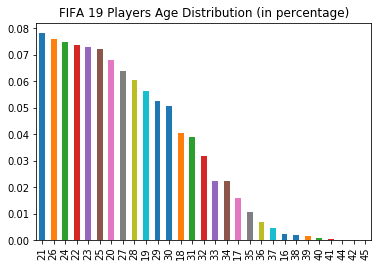

In [46]:
#Age distribution of the FIFA 19 Players?
age_vals = Analyze_DF.Age.value_counts()
print(age_vals)
(age_vals/Analyze_DF.shape[0]).plot(kind="bar");
plt.title("FIFA 19 Players Age Distribution (in percentage)");

In [47]:
#mean age by group, display top 20 Clubs in ascending order
Analyze_DF.groupby("Club")["Age"].mean().sort_values(ascending=True).head(20)

Club
FC Nordsjælland                   20.259259
FC Groningen                      21.423077
Bohemian FC                       21.480000
FC Sochaux-Montbéliard            21.678571
FC Admira Wacker Mödling          21.807692
LOSC Lille                        22.000000
Envigado FC                       22.035714
Stabæk Fotball                    22.074074
Barnsley                          22.107143
Derry City                        22.111111
Górnik Zabrze                     22.148148
Sligo Rovers                      22.157895
RB Leipzig                        22.178571
Vejle Boldklub                    22.185185
Bray Wanderers                    22.217391
Fortuna Sittard                   22.259259
Chamois Niortais Football Club    22.285714
Ajax                              22.300000
PSV                               22.366667
Hamburger SV                      22.366667
Name: Age, dtype: float64

In [48]:
#top 20 clubs with highest total player market value, and the highest average player wage
Analyze_DF.groupby("Club")["Value_Number_K"].sum().sort_values(ascending=False).head(20).plot(kind="bar");
plt.title("Top 20 clubs with the highest total Value");

In [49]:
Analyze_DF.groupby("Club")["Wage_Number_K"].mean().sort_values(ascending=False).head(20).plot(kind="bar");
plt.title("Top 20 clubs with the highest average wage");

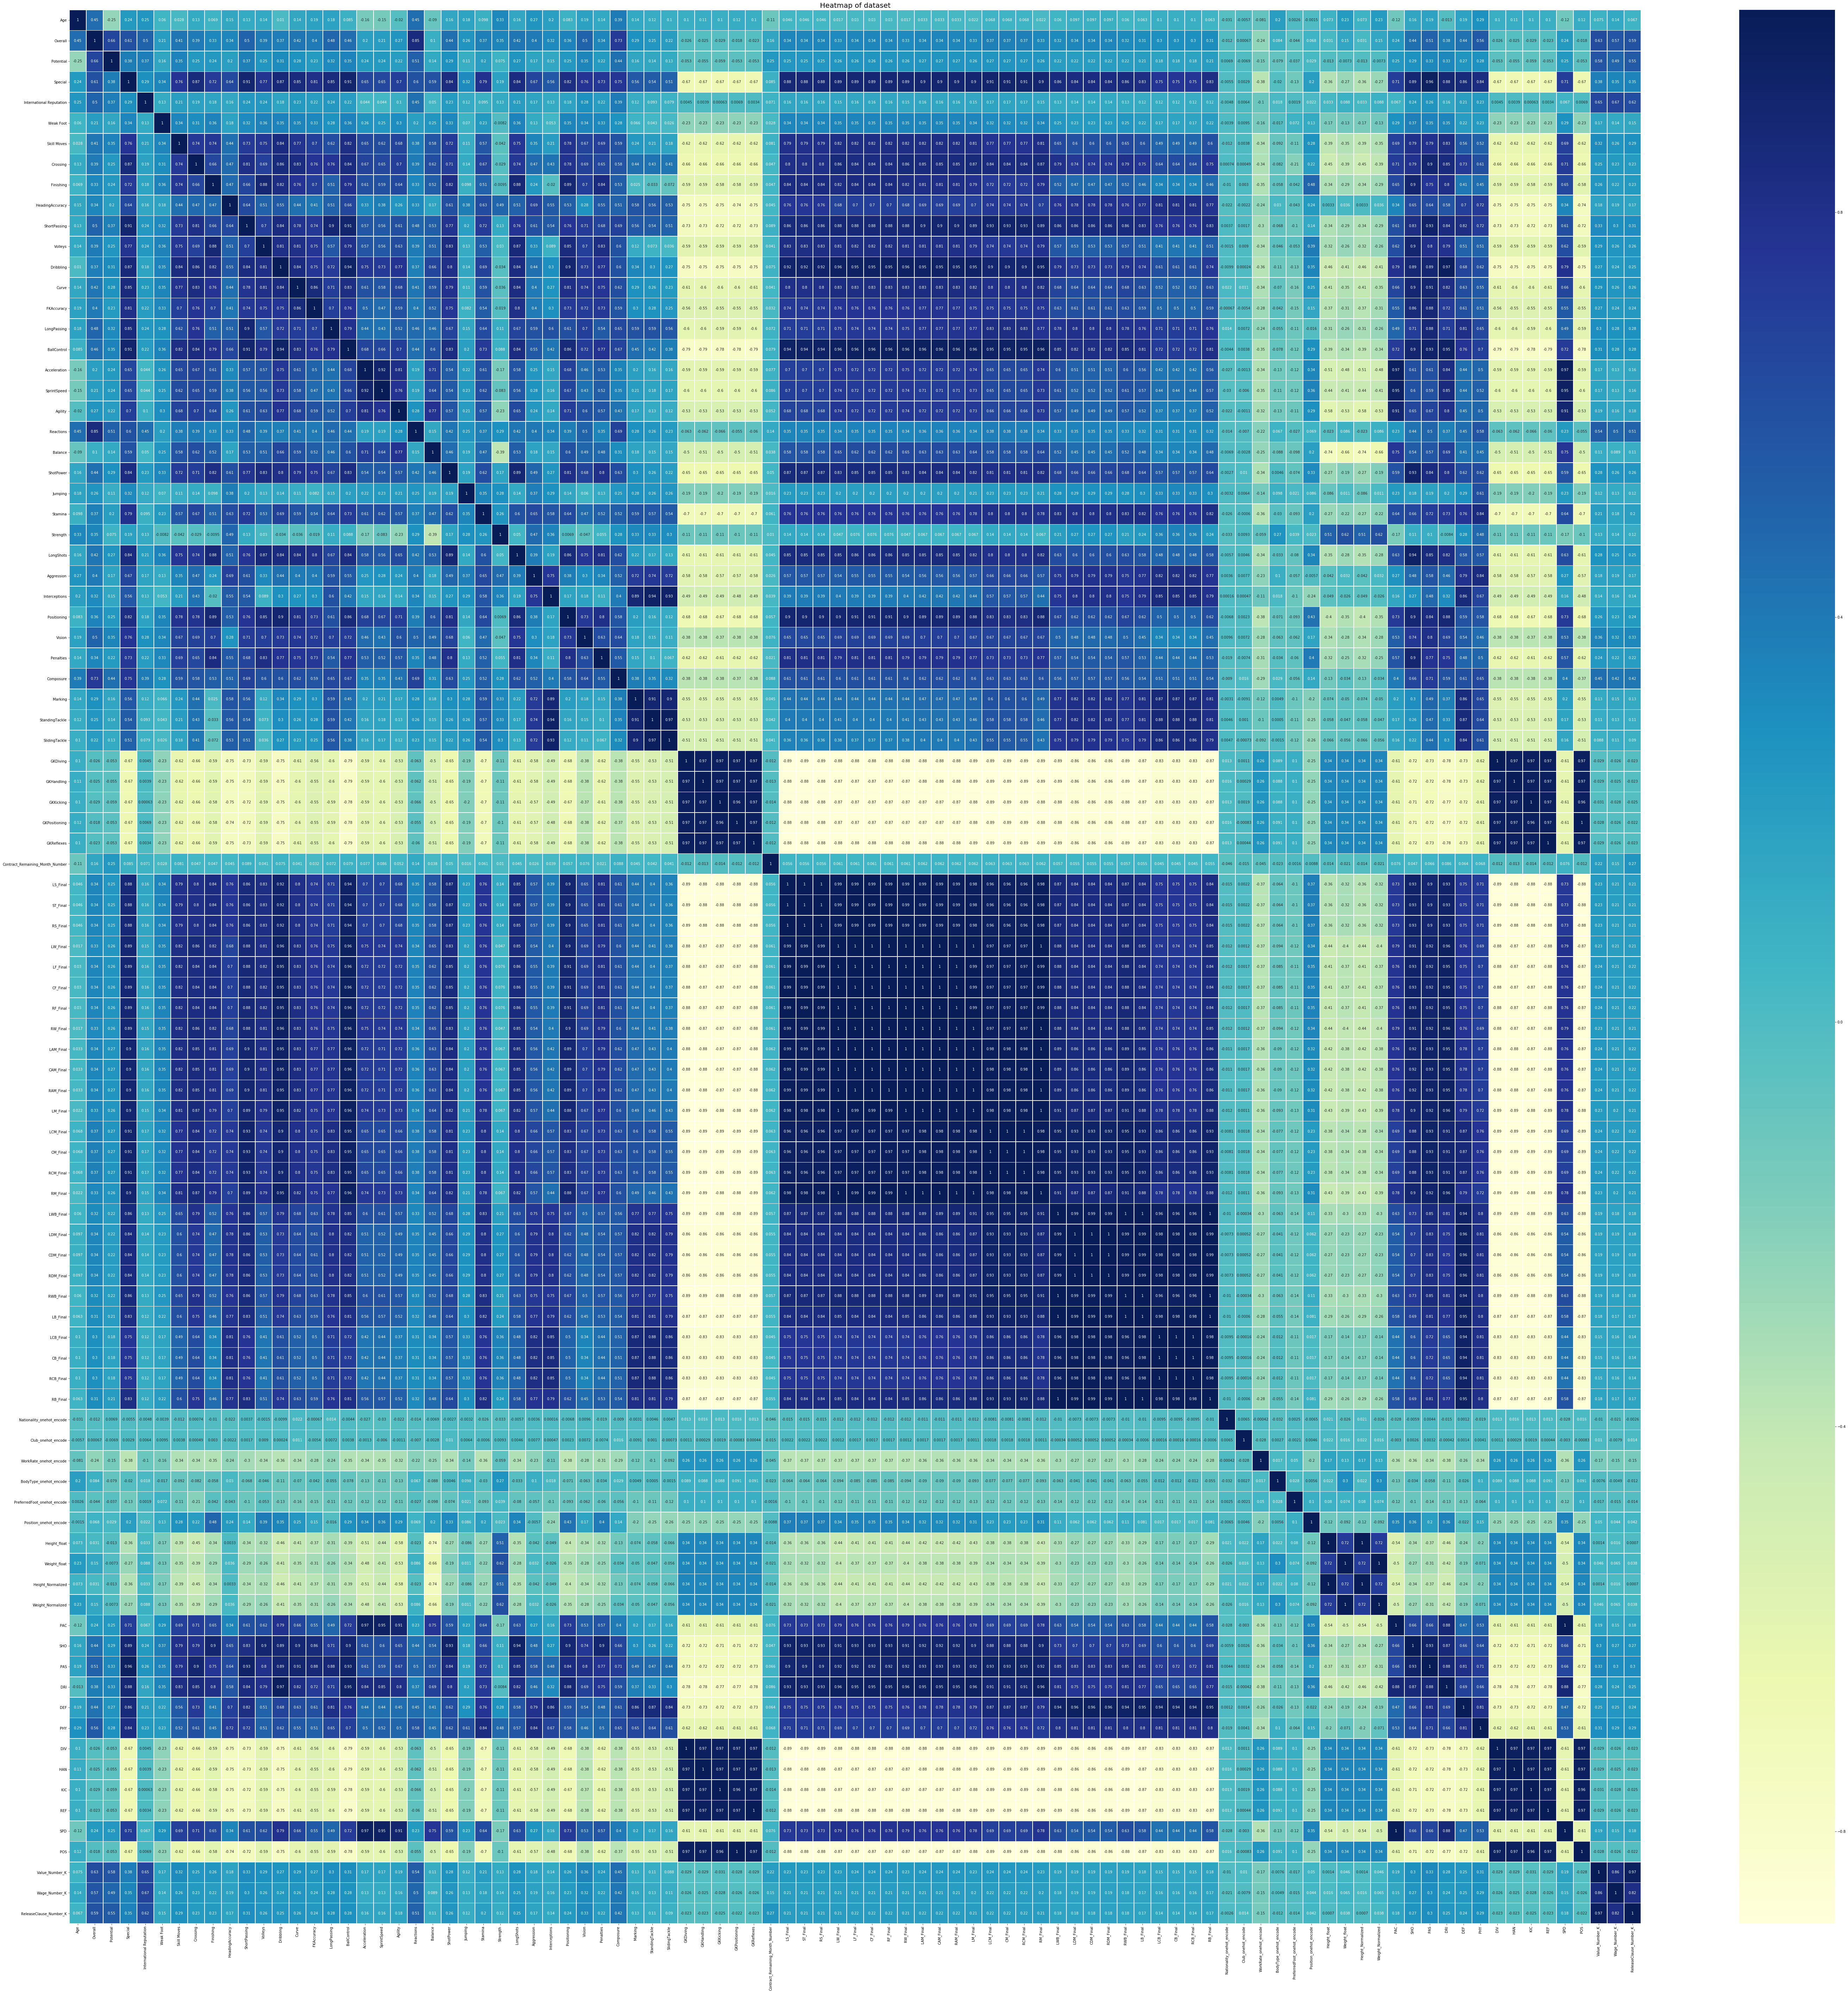

In [50]:
# Correlation heatmap
plt.rcParams['figure.figsize']=(100,100)
hm=sns.heatmap(Analyze_DF[['Age','Overall','Potential','Special','International Reputation','Weak Foot','Skill Moves','Crossing','Finishing',
                           'HeadingAccuracy','ShortPassing','Volleys','Dribbling','Curve','FKAccuracy','LongPassing','BallControl',
                           'Acceleration','SprintSpeed','Agility','Reactions','Balance','ShotPower','Jumping','Stamina','Strength',
                           'LongShots','Aggression','Interceptions','Positioning','Vision','Penalties','Composure','Marking','StandingTackle',
                           'SlidingTackle','GKDiving','GKHandling','GKKicking','GKPositioning','GKReflexes','Contract_Remaining_Month_Number',
                           'LS_Final','ST_Final','RS_Final','LW_Final','LF_Final','CF_Final','RF_Final','RW_Final','LAM_Final','CAM_Final',
                           'RAM_Final','LM_Final','LCM_Final','CM_Final','RCM_Final','RM_Final','LWB_Final','LDM_Final','CDM_Final',
                           'RDM_Final','RWB_Final','LB_Final','LCB_Final','CB_Final','RCB_Final','RB_Final','Nationality_onehot_encode',
                           'Club_onehot_encode','WorkRate_onehot_encode','BodyType_onehot_encode','PreferredFoot_onehot_encode',
                           'Position_onehot_encode','Height_float','Weight_float','Height_Normalized','Weight_Normalized','PAC','SHO','PAS',
                           'DRI','DEF','PHY','DIV','HAN','KIC','REF','SPD','POS','Value_Number_K','Wage_Number_K','ReleaseClause_Number_K',]].corr(), annot = True, linewidths=.5, cmap='YlGnBu')
hm.set_title(label='Heatmap of dataset', fontsize=20)
hm.figure.savefig("heatmap.png")
hm;

# Implementation #

## 1. Radar Plot Function #
Next is to create a function that can be used to display one or more players' basic ability as rader plot for display and comparision purpose. The following basic ability values will be used for the ploting:

#### For non-GK Positions:#
    PAC - Pace
    SHO - Shooting
    PAS - Passing
    DRI - Dribble
    DEF - Defense
    PHY - physical

#### For GK Positions:#
    DIV - GKDiving
    HAN - GKHandling
    KIC - GKKicking
    REF - GKReflexes
    SPD - Speed
    POS - GKPositioning

In [51]:
def plot_radar(data, player):
    """
    This function perform radar plotting to display one or more players' basic ability as rader plot for display and comparision purpose
    
    Parameter:
    data:   input dataset
    player: a player name or a list of player names to be displayed on radar plot

    To make the plot easy to read, up to 5 players can be displayed at the same time
    The cols used to generate Radar Plot depends on the first player's position. If this player is GK, then the columns are GK abilities.
    Otherwise will use non-GK abilities.
    """

    if type(player) != list: player = [player]
    
    # Basic Abailties
    cols_nGK  = ['PAC', 'SHO', 'PAS', 'DRI', 'DEF', 'PHY']
    cols_GK   = ['DIV', 'HAN', 'KIC', 'REF', 'SPD', 'POS']
    
    position_type = Analyze_DF.loc[Analyze_DF['Name'] == player[0], 'Position'].values[0]
    
    if position_type == "GK":
        cols = cols_GK
    else:
        cols = cols_nGK

    # Define Color
    colors = ['red', 'blue', 'green', 'yellow', 'black']

    # Divide the circle into six equal parts
    angles = np.linspace(0.1 * np.pi, 2.1 * np.pi, len(cols), endpoint=False)
    angles = np.concatenate((angles, [angles[0]]))

    # Initialize a polar image
    fig = plt.figure(figsize=(6, 6))
    ax = fig.add_subplot(111, polar=True)

    # Add player Name & Overall info
    for i, p in enumerate(player):
        overall = data.loc[data['Name'] == p, 'Overall'].values[0]
        ability = data.loc[data['Name'] == p, cols].values[0]
        ability = np.concatenate((ability, [ability[0]]))
        ax.plot(angles, ability, '-', linewidth=6, c=colors[i], label='%s Overall %s'%(p, overall))
        ax.fill(angles, ability, c=colors[i], alpha=0.25)

    # Add legend
    ax.legend(loc=[0.25, 1.15], fontsize=18)
    ax.set_yticklabels([])
    ax.set_thetagrids(angles * 180/np.pi, cols, fontsize=16)
    ax.grid(True)

    #plt.show()
    return fig

In [52]:
#Test Plotting one player
plot_radar(Analyze_DF, ['Cristiano Ronaldo']);

In [53]:
#Test comparing two players
plot_radar(Analyze_DF, ['Cristiano Ronaldo','L. Messi']);

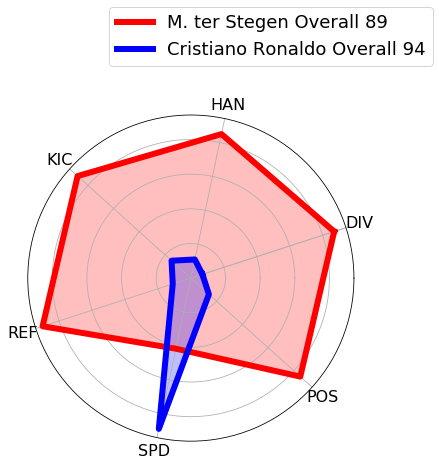

In [54]:
#Test Comparing with GK
plot_radar(Analyze_DF, ['M. ter Stegen','Cristiano Ronaldo']);

## 2. Find most Similar Player Function #
The project is to create a scouting tool. So if a target player is not available, or if a player in the main squad is leaving the team, then we must find a replacement ASAP. The function created here is to find the most similar players to the provided player in the market.

In [55]:
#Use this function to measure the similarity by Pearson correlation coefficient.
def sim_pearson(data, feature_to_compare, player1, player2):

    # Find the number of elements
    n = len(feature_to_compare)
    
    sum_1    = 0
    sum_2    = 0
    sum_1_sq = 0
    sum_2_sq = 0
    p_sum    = 0

    for it in feature_to_compare:
        value1 = data.loc[data['Name']==player1, it].values[0]
        value2 = data.loc[data['Name']==player2, it].values[0]
        
        # Add up all the preferences
        sum_1 += value1
        sum_2 += value2

        # Sum up the squares
        sum_1_sq += pow(value1,2)
        sum_2_sq += pow(value2,2)

        # Sum up the products
        p_sum += value1 * value2

    # Calculate Pearson score
    num = p_sum - (sum_1 * sum_2/n)
    den = sqrt((sum_1_sq - pow(sum_1, 2)/n) * (sum_2_sq - pow(sum_2, 2)/n))

    if den == 0:
        return 0

    r = num/den

    return r

In [56]:
def most_similar(data, player, n=4):
    """
    This function find the most similar player to the provided player
    
    Parameter:
    data:   input dataset
    player: a player name as the Recommendation template

    return:
    another player who is most similar to the Recommendation template player
    """
    scores = [ ]
    
    player_position = data.loc[data['Name']==player, 'Position'].values[0]
    player_overall  = data.loc[data['Name']==player, 'Overall'].values[0]
    
    if player_position == "GK":
        feature_to_compare = ['Overall', 'DIV', 'HAN', 'KIC', 'REF', 'SPD', 'POS']
    else:
        feature_to_compare = ['Overall', 'PAC', 'SHO', 'PAS', 'DRI', 'DEF', 'PHY']
    
    for candidate in data['Name']:
        if candidate != player:
            candidate_position = data.loc[data['Name']==candidate, 'Position'].values[0]
            candidate_overall  = data.loc[data['Name']==candidate, 'Overall'].values[0]
            if ((candidate_position == player_position) and (candidate_overall > player_overall*0.8)):
                scores += [(sim_pearson(data, feature_to_compare, player, candidate), candidate)]
    
    # Sort the list so the highest scores appear at the top scores.sort( )
    scores.sort( )
    scores.reverse( )
    return scores[0:n]

In [57]:
most_similar(Analyze_DF, "De Gea")

[(0.9979697445632761, 'S. Grytebust'),
 (0.9970520793624166, 'H. Tekin'),
 (0.9965434609181502, 'J. Zoet'),
 (0.9959920188096446, 'Sergio')]

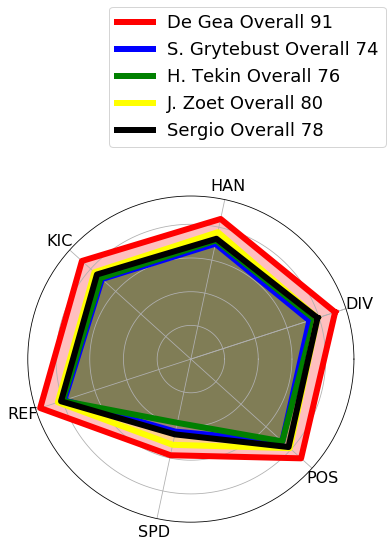

In [58]:
plot_radar(FIFA19_df, ['De Gea', 'S. Grytebust', 'H. Tekin', 'J. Zoet', 'Sergio']);

In [59]:
most_similar(Analyze_DF, "Cristiano Ronaldo")

[(0.9972719183155561, 'S. Agüero'),
 (0.9931681368002142, 'D. Sturridge'),
 (0.9905282832125651, 'H. Soudani'),
 (0.9888752517065001, 'N. Jørgensen')]

In [60]:
plot_radar(FIFA19_df, ['Cristiano Ronaldo','S. Agüero', 'D. Sturridge', 'H. Soudani', 'N. Jørgensen']);

The radar chart comparasion shows that the function to find similar players works as expected.

## 3. Find the best squad #

The idea is to select the highest Overall Value for each position for a certain formation. 

In [61]:
def find_best_squad(data, formation):
    """
    This function perform selection of the player with highest Overall Value for each provided position
    
    Parameter:
    data:           input dataset
    formation(str): a particular formation of a squad, which is a list of positions
    
    Returns:
    Position: The position from Input Parameter
    Player:   The Best Player Name for this Position
    Overall:  The Overall Value for this Best Player
    """
    BestSquad_DF = data[['Name', 'Age', 'Overall', 'Potential', 'Position']]
    BestSquad = []
    for i in formation:
        BestSquad.append([i,BestSquad_DF.loc[[BestSquad_DF[BestSquad_DF['Position'] == i]['Overall'].idxmax()]]['Name'].to_string(index = False),BestSquad_DF[BestSquad_DF['Position'] == i]['Overall'].max()])
        BestSquad_DF.drop(BestSquad_DF[BestSquad_DF['Position'] == i]['Overall'].idxmax(), inplace = True)

    return pd.DataFrame(np.array(BestSquad).reshape(11,3), columns = ['Position', 'Player', 'Overall']).to_string(index = False)

In [62]:
# Formation 433
Formation433 = ['GK', 'LB', 'CB', 'CB', 'RB', 'LM', 'CDM', 'RM', 'LW', 'ST', 'RW']
print('Best Squad of Formation 4-3-3')
print(find_best_squad(Analyze_DF, Formation433))

Best Squad of Formation 4-3-3
Position             Player Overall
     GK             De Gea      91
     LB            Marcelo      88
     CB           D. Godín      90
     CB          S. Umtiti      87
     RB        Azpilicueta      86
     LM      P. Aubameyang      88
    CDM    Sergio Busquets      89
     RM          K. Mbappé      88
     LW          Neymar Jr      92
     ST  Cristiano Ronaldo      94
     RW     Bernardo Silva      86


In [63]:
# Formation 3412
Formation3412 = ['GK', 'CB', 'CB', 'CB', 'LM', 'CM', 'CM', 'RM', 'CAM', 'ST', 'ST']
print ('Best Squad of Formation 3-4-1-2')
print (find_best_squad(Analyze_DF, Formation3412))

Best Squad of Formation 3-4-1-2
Position               Player Overall
     GK               De Gea      91
     CB             D. Godín      90
     CB            S. Umtiti      87
     CB           M. Benatia      86
     LM        P. Aubameyang      88
     CM               Thiago      86
     CM  S. Milinković-Savić      85
     RM            K. Mbappé      88
    CAM         A. Griezmann      89
     ST    Cristiano Ronaldo      94
     ST       R. Lewandowski      90


## 4. Create a model to predict a player's Value(transfer market value)#
This part aims to provide an algorithm to help the scout to evaluate the market value of a soccer player base on the soccer player’s attribute so that the scout can provide a report to the club managers, whether to buy or to sell this soccer player before making an official offer.

I will use MAE(Mean Absolute Error) as machine learning prediction model evaluation metric. MAE(Mean Absolute Error) is a measure of difference between two continuous variables. The output of the prediction model is the transfer market value of a soccer, which is a continuous variable. So it's suitable to use MAE as the metrics to measure the model performance.

The lower the MAE value is, the better the model performs.

First step is to do the feature selection to check which features are most important that decides a player's Value

In [64]:
market_value = Analyze_DF['Value_Number_K']
features     = Analyze_DF[['ID', 'Age','Overall','Potential','Special','International Reputation','Weak Foot','Skill Moves','Crossing','Finishing',
                           'HeadingAccuracy','ShortPassing','Volleys','Dribbling','Curve','FKAccuracy','LongPassing','BallControl',
                           'Acceleration','SprintSpeed','Agility','Reactions','Balance','ShotPower','Jumping','Stamina','Strength',
                           'LongShots','Aggression','Interceptions','Positioning','Vision','Penalties','Composure','Marking','StandingTackle',
                           'SlidingTackle','GKDiving','GKHandling','GKKicking','GKPositioning','GKReflexes','Wage_Number_K',
                           'ReleaseClause_Number_K','Contract_Remaining_Month_Number','LS_Final','ST_Final','RS_Final','LW_Final','LF_Final',
                           'CF_Final','RF_Final','RW_Final','LAM_Final','CAM_Final','RAM_Final','LM_Final','LCM_Final','CM_Final','RCM_Final',
                           'RM_Final','LWB_Final','LDM_Final','CDM_Final','RDM_Final','RWB_Final','LB_Final','LCB_Final','CB_Final',
                           'RCB_Final','RB_Final','Nationality_onehot_encode','Club_onehot_encode','WorkRate_onehot_encode',
                           'BodyType_onehot_encode','PreferredFoot_onehot_encode','Position_onehot_encode','Height_float','Weight_float',
                           'Height_Normalized','Weight_Normalized','PAC','SHO','PAS','DRI','DEF','PHY','DIV','HAN','KIC','REF','SPD','POS']]

# Perform Feature Selection using RFE and rank the Features by importance
# Use Ridge as the model
estimator = Ridge(alpha=100000, fit_intercept=True, normalize=True, copy_X=True, max_iter=1500,tol=1e-4, solver='auto')
rfe = RFE(estimator, n_features_to_select=10)
rfe.fit(features,market_value)

print(rfe.n_features_)
print(rfe.ranking_)
print(rfe.support_)
print(rfe.ranking_[1])
print(rfe.estimator_)

Feature_Names = features.head(n=0)
print("Features sorted by their rank:")
print(sorted(zip(map(lambda x: round(x, 4), rfe.ranking_), Feature_Names)))

10
[84 14  1  1 80  1  1  1 23 28 48  6 13 19 15 17  7  9 33 29 27  1 58 12
 49 26 50 18 47 63 25  4 16  1 64 66 68 77 73 70 74 78  2 82 20 40 42 41
 43 37 38 39 44 34 36 35 46 30 32 31 45 55 53 52 51 54 56 60 62 61 57 81
 83  1 67  1 65 59 69 24  1 21  8  5 10 11  3 76 72 71 79 22 75]
[False False  True  True False  True  True  True False False False False
 False False False False False False False False False  True False False
 False False False False False False False False False  True False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False  True False  True False False False False  True False False False
 False False False False False False False False False]
14
Ridge(alpha=100000, copy_X=True, fit_intercept=True, max_iter=1500,
   normalize=True, random_state=None, solver='auto', tol=0.0001)
Features s

Select the 10 most important features for model training

In [65]:
market_value = Analyze_DF['Value_Number_K']
#features     = Analyze_DF[['Composure','International Reputation','Overall','Potential','PreferredFoot_onehot_encode','Reactions',
#                            'Skill Moves','Weak Foot','Weight_Normalized','WorkRate_onehot_encode']]
#features     = Analyze_DF[['Overall','Potential','International Reputation','Reactions']]
features = Analyze_DF[['Age','Overall','Potential','Special','International Reputation','Skill Moves','Crossing','Finishing',
                       'HeadingAccuracy','ShortPassing','Volleys','Dribbling','Curve','FKAccuracy','LongPassing','BallControl',
                       'Acceleration','SprintSpeed','Agility','Reactions','Balance','ShotPower','Jumping','Stamina','Strength',
                       'LongShots','Aggression','Interceptions','Positioning','Vision','Penalties','Composure','Marking',
                       'StandingTackle','SlidingTackle','Wage_Number_K','ReleaseClause_Number_K','Contract_Remaining_Month_Number',
                       'LS_Final','ST_Final','RS_Final','LW_Final','LF_Final','CF_Final','RF_Final','RW_Final','LAM_Final',
                       'CAM_Final','RAM_Final','LM_Final','LCM_Final','CM_Final','RCM_Final','RM_Final','LWB_Final','LDM_Final',
                       'CDM_Final','RDM_Final','RWB_Final','LB_Final','LCB_Final','CB_Final','RCB_Final','RB_Final','PAC','SHO',
                       'PAS','DRI','DEF','PHY']]

# Shuffle and split the data into training and testing subsets
X_train,X_test,y_train,y_test=train_test_split(features,market_value,test_size=0.20,random_state=40)

In [66]:
# DecisionTreeRegressor as benchmark model
BMDTR = DecisionTreeRegressor(random_state=100)
BMDTR.fit(X_train, y_train)

# make prediction on X_test
y_pred = BMDTR.predict(X_test)

# Calculate the MAE of the Benchmark Model DecisionTreeRegressor, and timing the model
BM_MAE = mean_absolute_error(y_test, y_pred)
print("Mean Absolute Error of Benchmark Model DecisionTreeRegressor: {}".format(BM_MAE))

Mean Absolute Error of Benchmark Model DecisionTreeRegressor: 196.72727272727272


In [67]:
#create XGBoost Model
XGBTM = xgb.XGBRegressor(max_depth=5, learning_rate=0.1, n_estimators=160, silent=False, objective='reg:gamma')
XGBTM.fit(X_train, y_train)

# Make prediction on X_test
y_pred = XGBTM.predict(X_test)

# Calculate the MAE of the XGBoost Model
XGBTM_MAE = mean_absolute_error(y_test, y_pred)
print("Mean Absolute Error of XGBoost Model: {}".format(XGBTM_MAE))

Mean Absolute Error of XGBoost Model: 167.74344576463577


In [69]:
#XGBoost Model Tuning
#cv_params = {'n_estimators':     range(110, 180, 10),
#             'max_depth':        range(3, 8, 1),
#             'learning_rate':    [0.05,0.07,0.09,0.11,0.13,0.15]
#             }

cv_params = {'n_estimators':     range(130, 180, 10),
             'max_depth':        range(3, 6, 1),
             'learning_rate':    [0.08,0.09,0.1,0.11,0.12,0.13]
             }

model = xgb.XGBRegressor(n_estimators=110, max_depth=5, learning_rate=0.1, silent=False, objective='reg:gamma')

optimized_XGBTM = GridSearchCV(estimator=model, param_grid=cv_params, scoring='neg_mean_absolute_error', cv=3, verbose=2, n_jobs=4)
optimized_XGBTM.fit(X_train, y_train)

evalute_result = optimized_XGBTM.cv_results_
print('Result of each episode:{0}'.format(evalute_result))
print('The Best Optimized Parameters：{0}'.format(optimized_XGBTM.best_params_))
print('The best score of the Optimized XGBoost Model:{0}'.format(optimized_XGBTM.best_score_))

Fitting 3 folds for each of 90 candidates, totalling 270 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:   41.0s
[Parallel(n_jobs=4)]: Done 154 tasks      | elapsed:  3.0min
[Parallel(n_jobs=4)]: Done 270 out of 270 | elapsed:  5.3min finished


Result of each episode:{'mean_fit_time': array([3.7951568 , 3.56833863, 3.72306752, 3.97570427, 4.33308323,
       4.13361692, 4.31082082, 4.56847525, 4.9963092 , 5.13427512,
       4.70309345, 5.15954097, 5.53785682, 5.92916234, 6.32475893,
       3.30218212, 3.45476381, 3.74764792, 3.9800276 , 4.26426737,
       3.89325778, 4.49465148, 4.89359585, 5.22038198, 5.71837989,
       4.75761509, 4.92218614, 5.26160057, 5.57243729, 6.02555871,
       3.12630963, 3.38395556, 3.59405796, 3.95575873, 4.02125017,
       3.899575  , 4.09139665, 4.34073249, 4.85236255, 5.23400879,
       4.61566091, 4.98765572, 5.25162323, 5.45940526, 6.11234609,
       3.14426072, 3.43016394, 3.61965688, 3.96440053, 4.13062326,
       3.84837826, 4.19711336, 4.5278964 , 4.7842013 , 5.11333164,
       4.90023414, 4.96772091, 5.34472156, 5.81611824, 6.07143545,
       3.16819795, 3.43980416, 3.69777068, 4.01602515, 4.22381218,
       3.96839182, 4.39259473, 4.29119507, 4.67284099, 4.99232117,
       4.60901181, 4.

In [71]:
#Optimized XGBoost Model
XGBTM = xgb.XGBRegressor(max_depth=5, learning_rate=0.11, n_estimators=160, silent=False, objective='reg:gamma')
XGBTM.fit(X_train, y_train)

# Make prediction on X_test
y_pred = XGBTM.predict(X_test)

# Calculate the MAE of the XGBoost Model
XGBTM_MAE = mean_absolute_error(y_test, y_pred)
print("Mean Absolute Error of XGBoost Model: {}".format(XGBTM_MAE))

Mean Absolute Error of XGBoost Model: 165.68482275635793


In [75]:
y_pred = optimized_XGBTM.predict(X_test)

# Calculate the MAE of the XGBoost Model
optimized_XGBTM_MAE = mean_absolute_error(y_test, y_pred)
print("Mean Absolute Error of XGBoost Model: {}".format(optimized_XGBTM_MAE))

Mean Absolute Error of XGBoost Model: 165.68482275635793


The GridSearchCV technique further fine tuning the model parameters, and did improve the model prediction accuracy.

### Export the model as a pickle file #

In [78]:
pickle.dump(optimized_XGBTM, open('model.p', 'wb'))

# Conclusion#

The first part of this project serves as an ETL pipelline, which I implemented with in my Web APP. The second part of the project is data Visualization, which I also displayed in Web APP. The third part I created a method to combine most ability values value into 6 main features, and used these main features to generate Radar Chart, which will be used to verify the result of Web APP, find the similar players to the provided template player. I also create a function to use Pearson correlation coefficient to find the most similar players to the provided temlpate player, according to feature: Overall, Position, and the 6 main features I combined from players' ability values. Then the last two parts are to find the best squad, and train a ML model to predict a soccer player's market value.

I'm quite interesting in the function to find the similar players, and the model to predict a player's market value. I think it's very useful in real professional soccer industry, for both club managers, soccer scouts and also soccer fans. 

For improvement:
1. the most_similar() function to find the similar players, it took a few minutes to find and return a list of players that most similar to the provided template player. As you can find out that I add this function in my Web APP. For a Web APP a few minutes is a bit too long for user to wait for the resuls. So I think optimization can be done to improve the efficiency of this function.

2. I think another point can be enhanced. In my Web APP, after the APP return the list of most similar players, the APP can just generate the Radar Comparasion Chart of the template player as well as the four similar players, and display the chart in the webpage just after the return list. Furthermore, a comparasion tabel can be displayed on the webpage for user to easily compare the detailed attributes of each player.

3. I also think it's a good idea to add a function in web APP: let user choose a formation, find and display the best squad of each formation on the web page